In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from string import punctuation

import numpy as np
import pandas as pd
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.levenshtein import Levenshtein
from tqdm.notebook import tqdm

from sf_permits.config import logger, INTERIM_DATASET_PATH, STREET_NAMES_PATH

2024-12-20 17:30:47.783 | INFO     | sf_permits.config:<module>:11 - PROJ_ROOT path is: /home/tomaz/git/Politecnico/Subjects/data-information-quality/sf-permits


In [3]:
punctuation_regex = rf"[{punctuation}]"
punctuation_regex

'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]'

In [4]:
clean_location_df = pd.read_parquet(INTERIM_DATASET_PATH)
clean_location_df

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,...,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhood,Zipcode,Location,Record ID,latitude,longitude
8331,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
40704,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
40706,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
156945,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
174263,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111160,201601126900,8,otc alterations permit,2016-01-12,7281,006,1,<NA>,zoo,rd,...,5,wood frame (5),False,7,lakeshore,94132,"(37.732964055466674, -122.50232976247369)",1408953359813,37.732964,-122.50233
112267,201601257854,8,otc alterations permit,2016-01-25,7281,006,1,<NA>,zoo,rd,...,3,constr type 3,False,7,lakeshore,94132,"(37.732964055466674, -122.50232976247369)",1410156359813,37.732964,-122.50233
122051,201604265679,8,otc alterations permit,2016-04-26,7281,006,1,<NA>,zoo,rd,...,5,wood frame (5),False,7,lakeshore,94132,"(37.732964055466674, -122.50232976247369)",1420895359813,37.732964,-122.50233
130799,201607192764,8,otc alterations permit,2016-07-19,7281,006,1,<NA>,zoo,rd,...,5,wood frame (5),False,7,lakeshore,94132,"(37.732964055466674, -122.50232976247369)",1430584359813,37.732964,-122.50233


In [5]:
for string_column in clean_location_df.select_dtypes("string"):
    clean_location_df[string_column] = (
        clean_location_df[string_column]
        .str.lower()
        .str.replace(punctuation_regex, "", regex=True)
    )
clean_location_df.filter(like="Street")

,Street Number,Street Number Suffix,Street Name,Street Suffix
8331,<NA>,<NA>,<NA>,<NA>
40704,<NA>,<NA>,<NA>,<NA>
40706,<NA>,<NA>,<NA>,<NA>
156945,<NA>,<NA>,<NA>,<NA>
174263,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...
111160,1,<NA>,zoo,rd
112267,1,<NA>,zoo,rd
122051,1,<NA>,zoo,rd
130799,1,<NA>,zoo,rd


(0.0, 50.0)

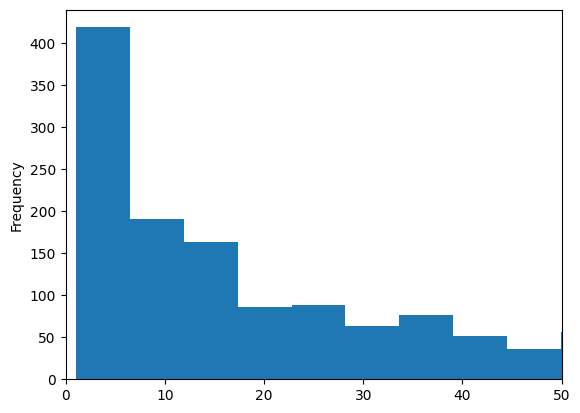

In [6]:
street_names = clean_location_df["Street Name"]
ax = street_names.value_counts().plot.hist(bins=1000)
ax.set_xlim(0, 50)

In [7]:
external_street_names_df = pd.read_csv(STREET_NAMES_PATH).convert_dtypes()
for string_column in external_street_names_df.select_dtypes("string"):
    external_street_names_df[string_column] = external_street_names_df[
        string_column
    ].str.lower()
external_street_names_df

,FullStreetName,StreetName,StreetType,PostDirection
0,01st st,01st,st,<NA>
1,02nd ave,02nd,ave,<NA>
2,02nd st,02nd,st,<NA>
3,02nd ti st,02nd ti,st,<NA>
4,03rd ave,03rd,ave,<NA>
...,...,...,...,...
2703,cravath st,cravath,st,<NA>
2704,sandpiper ln,sandpiper,ln,<NA>
2705,garden walk,garden,walk,<NA>
2706,la avanzada st,la avanzada,st,<NA>


In [8]:
normalised_external_street_names_df = external_street_names_df.copy()
for string_column in normalised_external_street_names_df.select_dtypes("string"):
    normalised_external_street_names_df[string_column] = (
        normalised_external_street_names_df[string_column]
        .str.lower()
        .str.replace(punctuation_regex, "", regex=True)
    )
normalised_external_street_names_df

,FullStreetName,StreetName,StreetType,PostDirection
0,01st st,01st,st,<NA>
1,02nd ave,02nd,ave,<NA>
2,02nd st,02nd,st,<NA>
3,02nd ti st,02nd ti,st,<NA>
4,03rd ave,03rd,ave,<NA>
...,...,...,...,...
2703,cravath st,cravath,st,<NA>
2704,sandpiper ln,sandpiper,ln,<NA>
2705,garden walk,garden,walk,<NA>
2706,la avanzada st,la avanzada,st,<NA>


In [9]:
normalised_external_street_names_df["StreetNameDirection"] = (
    normalised_external_street_names_df["StreetName"]
    + " "
    + normalised_external_street_names_df["PostDirection"].fillna("")
)
normalised_external_street_names_df

,FullStreetName,StreetName,StreetType,PostDirection,StreetNameDirection
0,01st st,01st,st,<NA>,01st
1,02nd ave,02nd,ave,<NA>,02nd
2,02nd st,02nd,st,<NA>,02nd
3,02nd ti st,02nd ti,st,<NA>,02nd ti
4,03rd ave,03rd,ave,<NA>,03rd
...,...,...,...,...,...
2703,cravath st,cravath,st,<NA>,cravath
2704,sandpiper ln,sandpiper,ln,<NA>,sandpiper
2705,garden walk,garden,walk,<NA>,garden
2706,la avanzada st,la avanzada,st,<NA>,la avanzada


In [10]:
(~clean_location_df["Street Name"].isin(external_street_names_df["StreetName"])).sum()

np.int64(1604)

In [11]:
full_name_match_df = normalised_external_street_names_df.reset_index(names="base_index").merge(street_names.reset_index(), left_on="FullStreetName", right_on="Street Name")
full_name_match_df

,base_index,FullStreetName,StreetName,StreetType,PostDirection,StreetNameDirection,index,Street Name
0,210,avenue d,avenue d,<NA>,<NA>,avenue d,95325,avenue d
1,210,avenue d,avenue d,<NA>,<NA>,avenue d,103333,avenue d
2,210,avenue d,avenue d,<NA>,<NA>,avenue d,115062,avenue d
3,213,avenue h,avenue h,<NA>,<NA>,avenue h,128822,avenue h
4,214,avenue i,avenue i,<NA>,<NA>,avenue i,30183,avenue i
...,...,...,...,...,...,...,...,...
2094,2642,mission bay blvd north,mission bay,blvd,north,mission bay north,5762,mission bay blvd north
2095,2642,mission bay blvd north,mission bay,blvd,north,mission bay north,2245,mission bay blvd north
2096,2642,mission bay blvd north,mission bay,blvd,north,mission bay north,2239,mission bay blvd north
2097,2647,avenue g,avenue g,<NA>,<NA>,avenue g,186555,avenue g


In [12]:
street_name_match_df = normalised_external_street_names_df.reset_index(names="base_index").merge(street_names.reset_index(), left_on="StreetName", right_on="Street Name")
street_name_match_df

,base_index,FullStreetName,StreetName,StreetType,PostDirection,StreetNameDirection,index,Street Name
0,0,01st st,01st,st,<NA>,01st,117896,01st
1,0,01st st,01st,st,<NA>,01st,120717,01st
2,0,01st st,01st,st,<NA>,01st,167113,01st
3,0,01st st,01st,st,<NA>,01st,32221,01st
4,0,01st st,01st,st,<NA>,01st,33240,01st
...,...,...,...,...,...,...,...,...
254467,2706,la avanzada st,la avanzada,st,<NA>,la avanzada,108253,la avanzada
254468,2706,la avanzada st,la avanzada,st,<NA>,la avanzada,132509,la avanzada
254469,2706,la avanzada st,la avanzada,st,<NA>,la avanzada,163004,la avanzada
254470,2706,la avanzada st,la avanzada,st,<NA>,la avanzada,172552,la avanzada


In [13]:
street_name_direction_match_df = normalised_external_street_names_df.reset_index(names="base_index").merge(street_names.reset_index(), left_on="StreetNameDirection", right_on="Street Name")
street_name_direction_match_df

,base_index,FullStreetName,StreetName,StreetType,PostDirection,StreetNameDirection,index,Street Name
0,2634,buena vista ave east,buena vista,ave,east,buena vista east,54595,buena vista east
1,2634,buena vista ave east,buena vista,ave,east,buena vista east,164543,buena vista east
2,2634,buena vista ave east,buena vista,ave,east,buena vista east,114019,buena vista east
3,2634,buena vista ave east,buena vista,ave,east,buena vista east,129991,buena vista east
4,2634,buena vista ave east,buena vista,ave,east,buena vista east,131634,buena vista east
...,...,...,...,...,...,...,...,...
235,2643,25th ave north,25th,ave,north,25th north,10043,25th north
236,2643,25th ave north,25th,ave,north,25th north,141762,25th north
237,2643,25th ave north,25th,ave,north,25th north,86587,25th north
238,2643,25th ave north,25th,ave,north,25th north,88443,25th north


In [14]:
match_indices = pd.concat([full_name_match_df["index"], street_name_match_df["index"], street_name_direction_match_df["index"]]).unique()
match_indices.size

197743

In [15]:
non_match_indices = clean_location_df.index.difference(match_indices)
non_match_indices.size

1157

In [16]:
wrong_street_name_df = clean_location_df.loc[non_match_indices]
wrong_street_name_df["Street Name"].value_counts()

Street Name
embarcadero center     807
maritime               118
edinburg               116
st marys                27
hallidie                17
phelan                  10
emmet                   10
2nd                      9
terry francois           7
lake merced hill so      6
st josephs               5
lake merced hill no      5
peace                    5
marsilly                 4
sgt john v young         3
mountain springs         2
Name: count, dtype: Int64

In [17]:
street_names = wrong_street_name_df["Street Name"]
street_names

468                 edinburg
1189                  phelan
1858                edinburg
2058                     2nd
2164      embarcadero center
                 ...        
198542    embarcadero center
198623              maritime
198721    embarcadero center
198744    embarcadero center
198758              maritime
Name: Street Name, Length: 1157, dtype: string

In [18]:
base_street_names = (normalised_external_street_names_df["StreetName"] + " " + normalised_external_street_names_df["PostDirection"].fillna("")).str.strip()
base_street_names

0              01st
1              02nd
2              02nd
3           02nd ti
4              03rd
           ...     
2703        cravath
2704      sandpiper
2705         garden
2706    la avanzada
2707         memory
Length: 2708, dtype: string

In [19]:
def get_matching_strings(
    base: pd.Series,
    target: pd.Series,
    similarity,
    block_length: int = 0,
) -> tuple[dict[int, list], dict[str, list]]:
    matching_indices: dict[int, list] = defaultdict(list)
    matching_values: dict[str, list] = defaultdict(list)  # Only for visualisation

    for base_index, base_value in tqdm(base.items(), total=len(base)):
        logger.info("Processing base value {}", base_value)
        block_key = base_value[:block_length]
        block = target[target.str.startswith(block_key)]
        logger.debug("{} candidates in block '{}'", len(block), block_key)
        for i, value in block.items():
            if value == base_value:
                continue
            if similarity(base_value, value):
                matching_indices[base_index].append(i)
                matching_values[base_value].append(value)
        number_matches = len(matching_indices[base_value])
        if number_matches == 0:
            logger.warning("No matches found for '{}'", base_value)
        else:
            logger.debug(
                "{} matches in for '{}'", len(matching_indices[base_value]), base_value
            )

    matching_indices = {key: value for key, value in matching_indices.items() if value}
    matching_values = {key: value for key, value in matching_values.items() if value}

    return matching_indices, matching_values

In [20]:
JACCARD_SIMILARITY_THRESHOLD = 0.32
JACCARD_JARO_SIMILARITY_THRESHOLD = 0.70
DIRECT_JARO_SIMILARITY_THRESHOLD = 0.93
REVERSE_JARO_SIMILARITY_THRESHOLD = 0.89


def jaccard(base: str, target: str, normalise: bool = True) -> float:
    base_words = base.split()
    target_words = target.split()
    intersection = sum(1 for target_word in target_words if target_word in base_words)
    result = intersection
    if normalise:
        union = len(set((*base_words, *target_words)))
        result /= union
    return result


def levenshtein(base: str, target: str) -> float:
    distance = Levenshtein().distance(base, target)
    combined_length = len(base) + len(target)
    return 1 - distance / combined_length


def hybrid_similarity(base: str, target: str) -> float:
    return (
        jaccard(base, target, normalise=False) >= 1
        and JaroWinkler().similarity(base, target) > JACCARD_JARO_SIMILARITY_THRESHOLD
    ) or (
        JaroWinkler().similarity(base, target) > DIRECT_JARO_SIMILARITY_THRESHOLD
        and JaroWinkler().similarity(base[::-1], target[::-1]) > REVERSE_JARO_SIMILARITY_THRESHOLD
    )


matching_indices, matching_names = get_matching_strings(
    base_street_names,
    street_names,
    hybrid_similarity,
    block_length=0,
)
len(matching_indices)

  0%|          | 0/2708 [00:00<?, ?it/s]

2024-12-20 17:30:51.628 | INFO     | __main__:get_matching_strings:11 - Processing base value 01st
2024-12-20 17:30:51.629 | DEBUG    | __main__:get_matching_strings:14 - 1151 candidates in block ''
2024-12-20 17:30:51.635 | WARNING  | __main__:get_matching_strings:23 - No matches found for '01st'
2024-12-20 17:30:51.635 | INFO     | __main__:get_matching_strings:11 - Processing base value 02nd
2024-12-20 17:30:51.636 | DEBUG    | __main__:get_matching_strings:14 - 1151 candidates in block ''
2024-12-20 17:30:51.642 | WARNING  | __main__:get_matching_strings:23 - No matches found for '02nd'
2024-12-20 17:30:51.642 | INFO     | __main__:get_matching_strings:11 - Processing base value 02nd
2024-12-20 17:30:51.643 | DEBUG    | __main__:get_matching_strings:14 - 1151 candidates in block ''
2024-12-20 17:30:51.651 | WARNING  | __main__:get_matching_strings:23 - No matches found for '02nd'
2024-12-20 17:30:51.651 | INFO     | __main__:get_matching_strings:11 - Processing base value 02nd ti
2

16

In [21]:
total_matches = 0
for base_value, matches in matching_names.items():
    total_matches += len(matches)
    print(base_value.rjust(20), "\t", len(matches))
print(total_matches)

           edinburgh 	 116
              emmett 	 10
                john 	 3
                lake 	 11
         lake merced 	 11
    lake merced hill 	 11
             marsily 	 4
      medical center 	 807
     mountain spring 	 2
       saint josephs 	 5
         saint marys 	 27
sergeant john v young 	 3
    terry a francois 	 7
     the embarcadero 	 807
lake merced hill north 	 11
lake merced hill south 	 11
1846


In [22]:
for match_df in (full_name_match_df, street_name_direction_match_df, street_name_match_df):
    for base_index, index in match_df[["base_index", "index"]].itertuples(index=False):
        try:
            matching_indices[base_index].append(index)
        except KeyError:
            matching_indices[base_index] = [index]

Deduplicate matches

In [23]:
reversed_matching_indices = defaultdict(list)
for base_index, target_indices in matching_indices.items():
    for target_index in target_indices:
        reversed_matching_indices[target_index].append(base_index)
len(reversed_matching_indices)

198735

In [24]:
unique_reversed_matching_indices: dict[int, int] = {}
for target_index, base_indices in reversed_matching_indices.items():
    if len(base_indices) == 1:
        unique_reversed_matching_indices[target_index] = base_indices[0]
    jaro_similarities = [
        JaroWinkler().similarity(
            base_street_names.loc[base_index],
            clean_location_df.loc[target_index, "Street Name"],
        )
        for base_index in base_indices
    ]
    unique_reversed_matching_indices[target_index] = base_indices[np.argmax(jaro_similarities)]

In [25]:
normalised_external_street_names_df

,FullStreetName,StreetName,StreetType,PostDirection,StreetNameDirection
0,01st st,01st,st,<NA>,01st
1,02nd ave,02nd,ave,<NA>,02nd
2,02nd st,02nd,st,<NA>,02nd
3,02nd ti st,02nd ti,st,<NA>,02nd ti
4,03rd ave,03rd,ave,<NA>,03rd
...,...,...,...,...,...
2703,cravath st,cravath,st,<NA>,cravath
2704,sandpiper ln,sandpiper,ln,<NA>,sandpiper
2705,garden walk,garden,walk,<NA>,garden
2706,la avanzada st,la avanzada,st,<NA>,la avanzada


In [26]:
final_match_df = pd.Series(unique_reversed_matching_indices, name="base_index").reset_index().rename(columns={"index": "target_index"})
final_match_df

,target_index,base_index
0,468,768
1,1858,768
2,5153,768
3,8405,768
4,13491,768
...,...,...
198730,55940,2661
198731,69552,2661
198732,112887,2661
198733,122649,2661


In [27]:
street_clean_location_df = final_match_df.join(external_street_names_df[["StreetName", "StreetType"]], on="base_index").join(clean_location_df, on="target_index", how="right")
street_clean_location_df

,target_index,base_index,StreetName,StreetType,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,...,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhood,Zipcode,Location,Record ID,latitude,longitude
NaN,8331,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,40704,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,40706,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,156945,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,174263,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198723.0,111160,2625.0,zoo,rd,201601126900,8,otc alterations permit,2016-01-12,7281,006,...,5,wood frame 5,False,7,lakeshore,94132,37732964055466674 12250232976247369,1408953359813,37.732964,-122.50233
198724.0,112267,2625.0,zoo,rd,201601257854,8,otc alterations permit,2016-01-25,7281,006,...,3,constr type 3,False,7,lakeshore,94132,37732964055466674 12250232976247369,1410156359813,37.732964,-122.50233
198725.0,122051,2625.0,zoo,rd,201604265679,8,otc alterations permit,2016-04-26,7281,006,...,5,wood frame 5,False,7,lakeshore,94132,37732964055466674 12250232976247369,1420895359813,37.732964,-122.50233
198726.0,130799,2625.0,zoo,rd,201607192764,8,otc alterations permit,2016-07-19,7281,006,...,5,wood frame 5,False,7,lakeshore,94132,37732964055466674 12250232976247369,1430584359813,37.732964,-122.50233


In [28]:
street_clean_location_df["Street Name"] = street_clean_location_df["StreetName"].combine_first(street_clean_location_df["Street Name"])
street_clean_location_df["Street Suffix"] = street_clean_location_df["StreetType"].combine_first(street_clean_location_df["Street Suffix"])
final_df = street_clean_location_df.drop(columns=["StreetName", "StreetType"])
final_df

,target_index,base_index,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,...,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhood,Zipcode,Location,Record ID,latitude,longitude
NaN,8331,NaN,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,40704,NaN,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,40706,NaN,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,156945,NaN,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
NaN,174263,NaN,<NA>,<NA>,<NA>,NaT,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,False,<NA>,None,None,<NA>,<NA>,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198723.0,111160,2625.0,201601126900,8,otc alterations permit,2016-01-12,7281,006,1,<NA>,...,5,wood frame 5,False,7,lakeshore,94132,37732964055466674 12250232976247369,1408953359813,37.732964,-122.50233
198724.0,112267,2625.0,201601257854,8,otc alterations permit,2016-01-25,7281,006,1,<NA>,...,3,constr type 3,False,7,lakeshore,94132,37732964055466674 12250232976247369,1410156359813,37.732964,-122.50233
198725.0,122051,2625.0,201604265679,8,otc alterations permit,2016-04-26,7281,006,1,<NA>,...,5,wood frame 5,False,7,lakeshore,94132,37732964055466674 12250232976247369,1420895359813,37.732964,-122.50233
198726.0,130799,2625.0,201607192764,8,otc alterations permit,2016-07-19,7281,006,1,<NA>,...,5,wood frame 5,False,7,lakeshore,94132,37732964055466674 12250232976247369,1430584359813,37.732964,-122.50233


In [30]:
final_wrong_street_name_mask = (~final_df["Street Name"].isin(external_street_names_df["StreetName"]))
final_wrong_street_name_mask.sum()

np.int64(165)

In [36]:
final_df.loc[final_wrong_street_name_mask, "Street Name"].value_counts(dropna=False)

Street Name
maritime    118
hallidie     17
phelan       10
2nd           9
<NA>          6
peace         5
Name: count, dtype: Int64

```python
for base_index, target_indices in tqdm(matching_indices.items()):
    logger.info("Processing base {}", base_index)
    locations = clean_location_df.loc[target_indices + [base_index]][["latitude", "longitude"]]
    if locations.isna().any().any():
        logger.warning("NaN found in location, dropping")
        locations = locations.dropna()
    clustering = DBSCAN(eps=1e-3, min_samples=3)
    clusters = clustering.fit_predict(locations)
    logger.debug("Unique cluster labels: {}", np.unique(clusters))
    base_cluster = clusters[-1]
    if base_cluster == -1:
        logger.debug("Skipping outlying base")
        continue
    for target_index, target_cluster in zip(target_indices, clusters[:-1]):
        previous_name = clean_location_df.loc[target_index, "Street Name"]
        new_name = clean_location_df.loc[base_index, "Street Name"]
        if target_cluster != base_cluster:
            logger.debug("Skipping target street name '{}' and base '{}'", previous_name, new_name)
            continue
        logger.debug("Replacing target street name '{}' with base '{}'", previous_name, new_name)
        clean_location_df.loc[target_index, "Street Name"] = new_name
```